In [24]:
import numpy as np
import os
import cv2
import math
from matplotlib import pyplot as plt


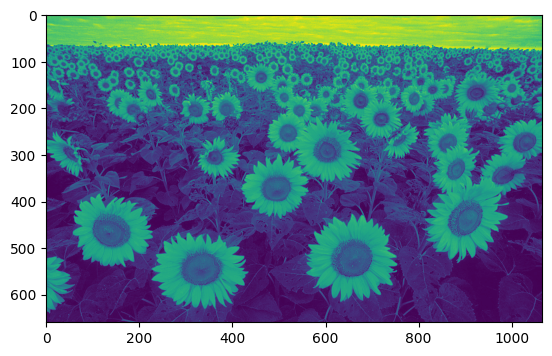

In [25]:
og_im = cv2.imread("sunflowers.jpeg")
#im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im = og_im.astype(float).mean(2)/255
plt.imshow(im)
plt.show()

level 0:


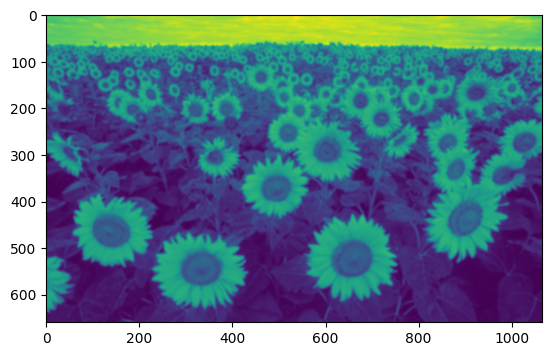

level 1:


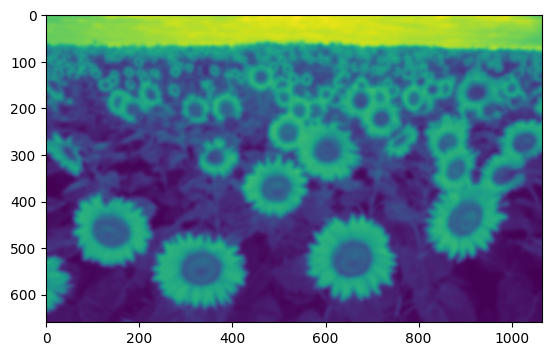

level 2:


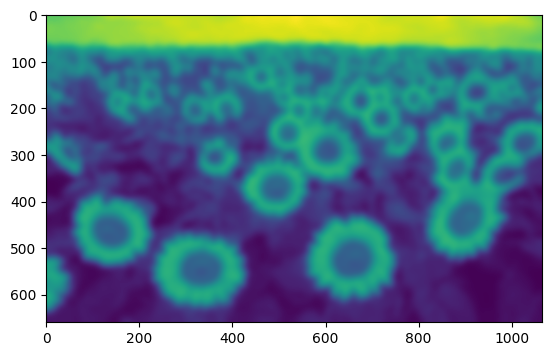

level 3:


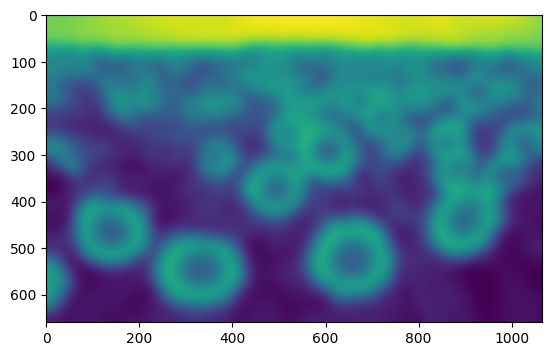

level 4:


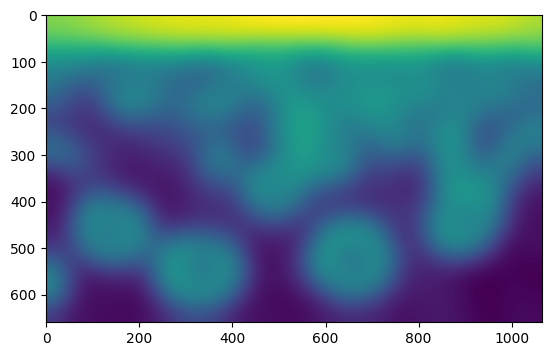

level 5:


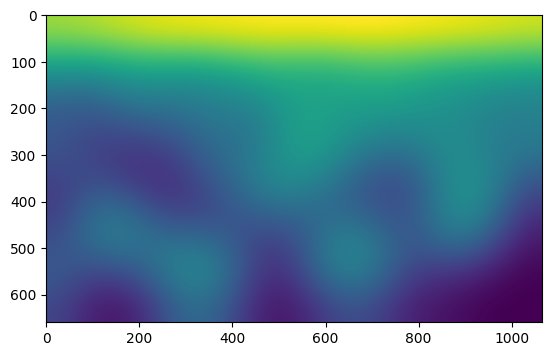

level 6:


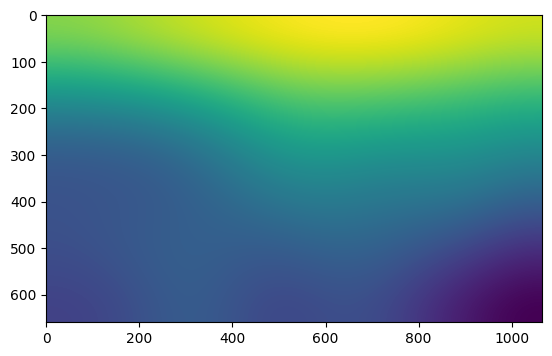

In [26]:
#part 8.1

def scaleSpaced(im, sigma, n):
    ''' im_scales is a list con- taining the scale space pyramid of the original image im.
    here we do the naïve implementation with increasing widths of Gaussians and no image downsampling, 
    to make the exercise easier. 
    In other words im_scales is not a pyramid in image sizes; only in scale space
    
    Gaussian kernel with standard deviation sigma · 2i, where i = 0,1,...,n-1'''
    im_scales = []
    for i in range(n):
        sigma_i = sigma * (2 ** i)
        blurred_im = cv2.GaussianBlur(im, (0,0), sigmaX = sigma_i )
        im_scales.append(blurred_im)
    return im_scales

sigma = 2
n = 7
im_scales = scaleSpaced(im, sigma, n)

for i, image in enumerate(im_scales):
    print(f'level {i}:')
    plt.imshow(image)
    plt.show()


level 0:


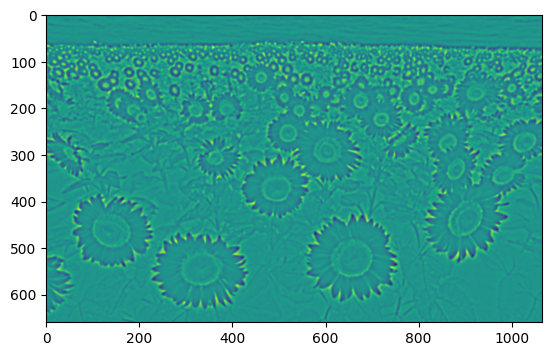

level 1:


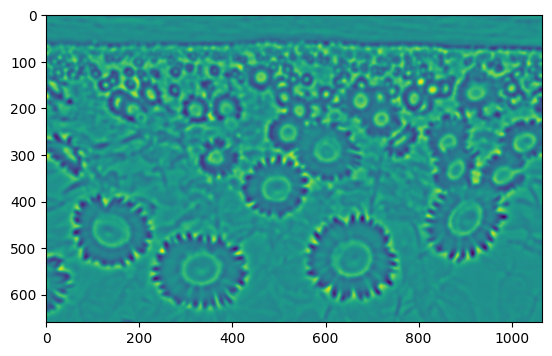

level 2:


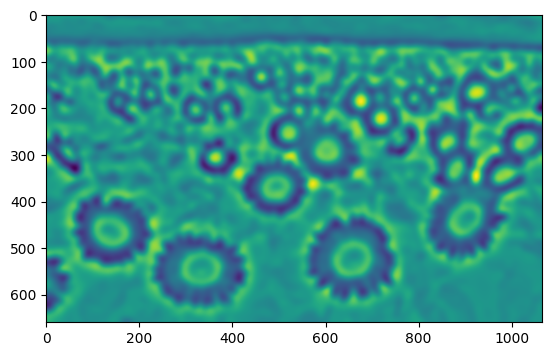

level 3:


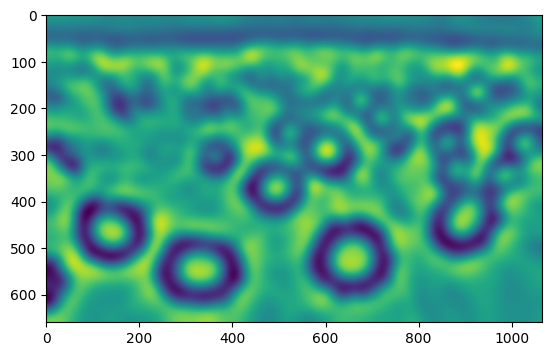

level 4:


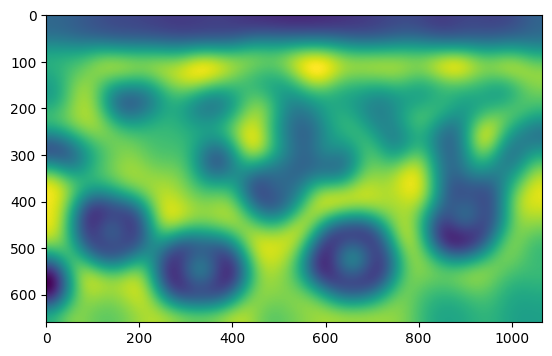

level 5:


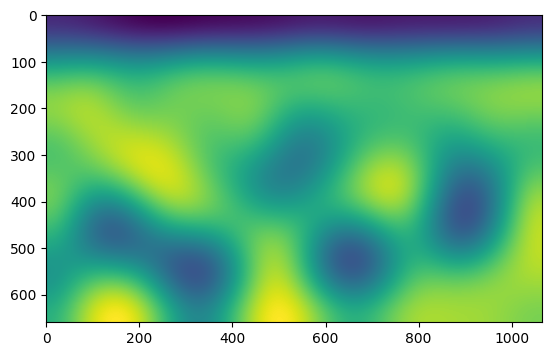

In [27]:
#ex 8.2
def differenceOfGaussians(im, sigma, n):
    '''DoG is a list of scale space DoGs of the original image im. 
    Like the scaleSpaced function, the returned images are all the same size as the original.'''
    im_scales = scaleSpaced(im, sigma, n)
    DoGs = []
    for i in range(1, n):
        dog = im_scales[i] - im_scales[i-1]
        DoGs.append(dog)
    return DoGs

DoGs = differenceOfGaussians(im, sigma, n)

for i, image in enumerate(DoGs):
    print(f'level {i}:')
    plt.imshow(image)
    plt.show()

i : 0
i : 1
i : 2
i : 3
i : 4
i : 5
i : 6
detected blobs


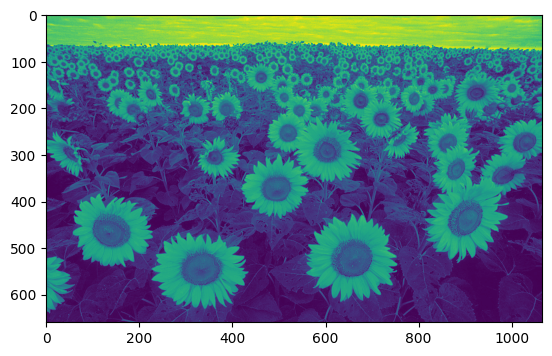

In [28]:
#part 8.3
def detectBlobs(im, sigma, n, tau):
    '''blobs are the BLOBs (pixels) of the original image im with
    a DoG magnitude larger than a threshold tau'''
    DoGs = differenceOfGaussians(im, sigma, n)
    #print(len(DoGs)) = 6
    blobs = []
    MaxDoG = []
    for dog in DoGs: # Compute MaxDoG for each scale
        MaxDoG.append(cv2.dilate(abs(dog), np.ones((3,3))))
    
    for i in range(n):
        print(f'i : {i}')
        if i == 6:
            break
        # Non-maximum suppression: The goal of non-maximum suppression is to keep only 
        #the most significant features (e.g., edges, corners, or keypoints) in an image while discarding the rest.
        for x in range(1, im.shape[0] - 1):
            for y in range(1, im.shape[1] - 1):
                pixel_value = DoGs[i][x,y] #current pixel value
                #if greater than tau, than compare to its neighbours. And if it's a local maximum, then it's a blob.
                if np.abs(pixel_value) > tau:
                    is_max = True
                    for dx in range(-1, 2):
                        for dy in range(-1, 2):
                            if (dx != 0 or dy != 0) and np.abs(pixel_value) < MaxDoG[i][x + dx, y + dy]:
                                    is_max = False
                                    break
                        if not is_max:
                            break
                    if is_max:
                        blobs.append((x,y,sigma*(2**i)))
    return blobs

tau = 0.1
blobs = detectBlobs(im, sigma, n, tau)
#draw circles around blobs
for blob in blobs:
    x,y,scale = blob
    cv2.circle(og_im, (y,x), int(scale), (0, 255, 0), 2)

print("detected blobs")
plt.imshow(im)
plt.show()

#not amazing results...

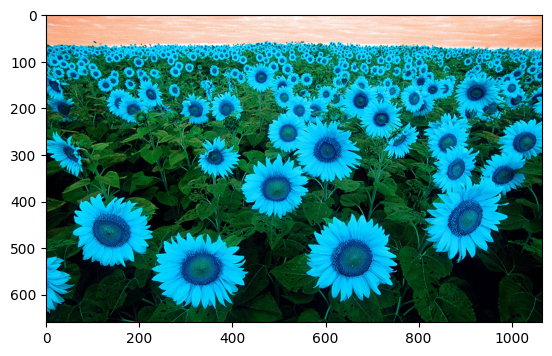

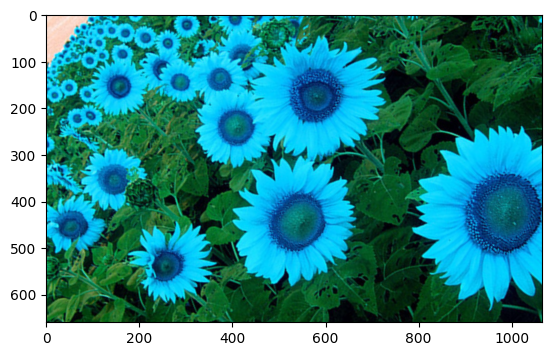

In [49]:
#part 8.4

og_im = cv2.imread("sunflowers.jpeg")
plt.imshow(og_im)
plt.show()
im = og_im.astype(float).mean(2)/255


def transformIm(im, theta, s):
    """returns a scaled and rotated version of im. 
    Theta = rot angle
    s = scale
    """
    height, width = im.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), theta, s)
    r_im = cv2.warpAffine(im, rotation_matrix, (width, height))
    return r_im

theta = 45
s = 2

r_im = transformIm(og_im, theta, s)
plt.imshow(r_im)
plt.show()

(660, 1066, 3)
(660, 1066, 3)
(660, 1066)


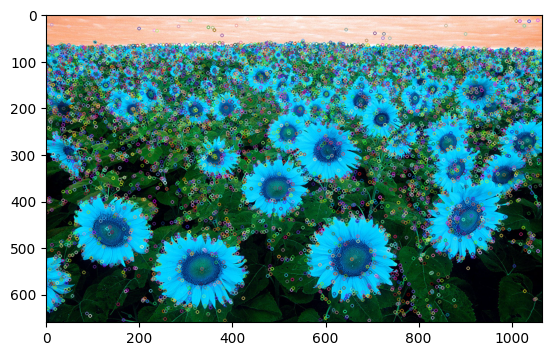

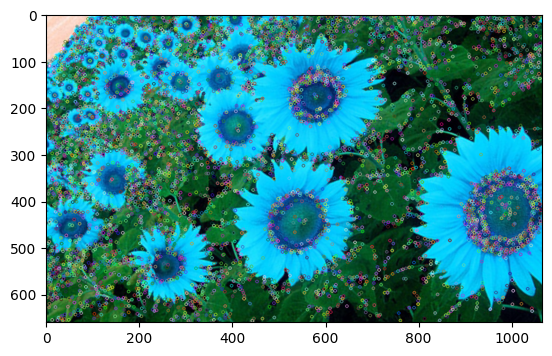

In [52]:
#part 8.5

sift = cv2.SIFT_create() #creates SIFT detector

print(og_im.shape)
print(r_im.shape)
print(im.shape)
if r_im is None:
    print("r_im is none!!" )

r_im = cv2.convertScaleAbs(r_im)
im = cv2.convertScaleAbs(im)
if r_im.dtype != np.uint8:
    print("r_im is not uint8!!")
#detection of keypoints and descriptors of og and transformed image
keypoints_original, descriptors_original = sift.detectAndCompute(og_im, None)
keypoints_transformed, descriptors_transformed = sift.detectAndCompute(r_im, None)

#draw them on the images
og_with_keypoints = cv2.drawKeypoints(og_im, keypoints_original, None)
r_with_keypoints = cv2.drawKeypoints(r_im, keypoints_transformed, None)

plt.imshow(og_with_keypoints)
plt.show()

plt.imshow(r_with_keypoints)
plt.show()


In [53]:
print("Original Image - Min:", og_im.min(), "Max:", og_im.max())
print("Uint8 Image - Min:", r_im.min(), "Max:", r_im.max()) 


Original Image - Min: 0 Max: 255
Uint8 Image - Min: 0 Max: 255


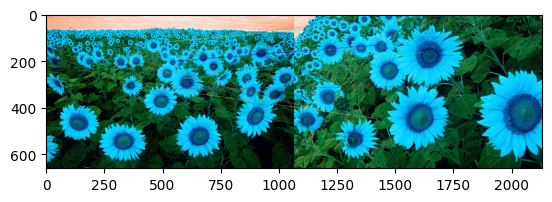

In [56]:
# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
# Match descriptors
matches = bf.match(descriptors_original, descriptors_transformed)
# Sort matches based on their distances
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches
matching_image = cv2.drawMatches(og_im, keypoints_original, r_im, keypoints_transformed, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(matching_image)
plt.show()


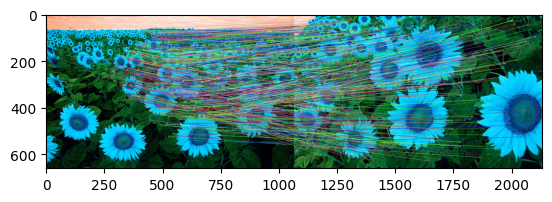

In [63]:
#Filter your matches with the ratio test
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf.knnMatch(descriptors_original, descriptors_transformed, k=2)
# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.2 * n.distance:
        good_matches.append(m)

matching_image = cv2.drawMatches(og_im, keypoints_original, r_im, keypoints_transformed, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(matching_image)
plt.show()


#THIS DOESNT REALLY LOOK RIGHT??? it seems to add matches

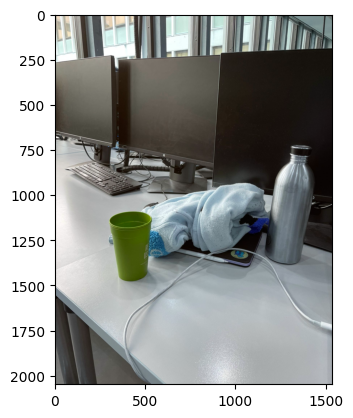

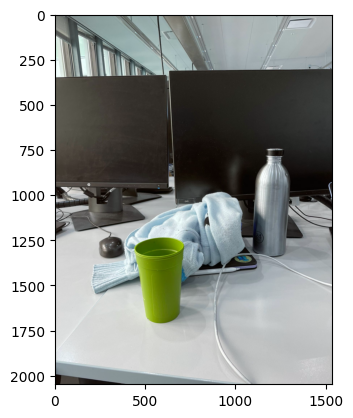

In [64]:
#part 8.6
'''Take two photos of the same scene from different angles using e.g. your smartphone and find matching SIFT features.'''

im1 = cv2.imread("scene1.jpeg")
im2 = cv2.imread("scene2.jpeg")

plt.imshow(im1)
plt.show()
plt.imshow(im2)
plt.show()

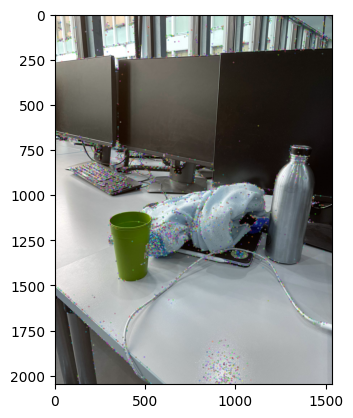

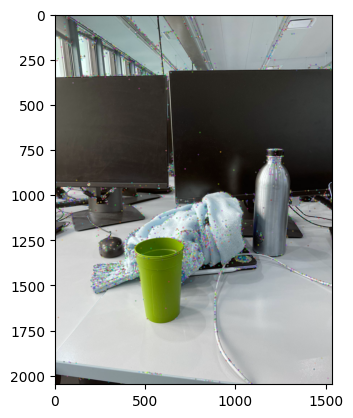

In [65]:
sift2 = cv2.SIFT_create() #creates SIFT detector

#detection of keypoints and descriptors of og and transformed image
keypoints1, descriptors1 = sift2.detectAndCompute(im1, None)
keypoints2, descriptors2 = sift.detectAndCompute(im2, None)

#draw them on the images
one_with_keypoints = cv2.drawKeypoints(im1, keypoints1, None)
two_with_keypoints = cv2.drawKeypoints(im2, keypoints2, None)

plt.imshow(one_with_keypoints)
plt.show()

plt.imshow(two_with_keypoints)
plt.show()

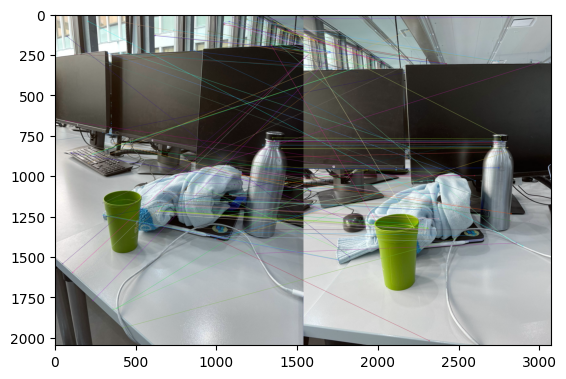

In [70]:
bf2 = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf2.knnMatch(descriptors1, descriptors2, k=2)
# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

matching_image2 = cv2.drawMatches(im1, keypoints1, im2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(matching_image2)
plt.show()
